In [14]:
# import packages
import openeo
import json
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry
import xarray as xr

In [2]:
# connect to copernicus
conn = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [3]:
# aoi of Prepuna province
aoi = json.load(open('acon.geojson'))

# check the aoi
region = aoi['features'][0]['geometry']
geom = shapely.geometry.shape(region)
centroid = geom.centroid
center_latlon = [centroid.y, centroid.x]

m = folium.Map(location=center_latlon, zoom_start=6)

folium.GeoJson(aoi).add_to(m)
m

In [4]:
# time range
start = "2020-04-01"
end = "2021-03-31"

In [5]:
# load S2 data
s2 = conn.load_collection(
    "SENTINEL2_L1C",
    spatial_extent=region,
    temporal_extent=[start, end],
    bands=["B04"]
)

scl = conn.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=region,
    temporal_extent=[start, end],
    bands=["SCL"]
)


In [6]:
# cloud mask
cloud_mask = ( (scl == 8) | (scl == 9) | (scl == 3) | (scl == 10) ) * 1.0 # times one forces to binary

s2 = s2.mask(cloud_mask) 

In [7]:
s2

In [8]:
# make binary mask (valid pixels = 1)
clear_mask = s2.reduce_bands("max") > 0

In [9]:
# Resample daily: max means if any image on that day has clear pixel -> clear
daily_clear = clear_mask.aggregate_temporal_period(
    period="day",
    reducer="max"
)

In [10]:
# total number of clear days per pixel
clear_days = daily_clear.reduce_dimension(dimension="t", reducer="sum")

# compute percentage (divide by 365)
clear_pct = clear_days / 365 * 100


In [11]:
# mask the output within the region boundaries
polygon = shapely.geometry.shape(region)
clear_pct_masked = clear_pct.mask_polygon(region)


In [12]:
clear_pct_masked.save_result(format="NetCDF").execute_batch(
    outputfile="results/cloud_free_percentage.nc"
)

0:00:00 Job 'j-25070808203147298b6354cc052ff024': send 'start'
0:00:13 Job 'j-25070808203147298b6354cc052ff024': created (progress 0%)
0:00:19 Job 'j-25070808203147298b6354cc052ff024': created (progress 0%)
0:00:25 Job 'j-25070808203147298b6354cc052ff024': created (progress 0%)
0:00:33 Job 'j-25070808203147298b6354cc052ff024': created (progress 0%)
0:00:43 Job 'j-25070808203147298b6354cc052ff024': running (progress N/A)
0:00:55 Job 'j-25070808203147298b6354cc052ff024': running (progress N/A)
0:01:11 Job 'j-25070808203147298b6354cc052ff024': running (progress N/A)
0:01:30 Job 'j-25070808203147298b6354cc052ff024': running (progress N/A)
0:01:54 Job 'j-25070808203147298b6354cc052ff024': running (progress N/A)
0:02:24 Job 'j-25070808203147298b6354cc052ff024': running (progress N/A)
0:03:01 Job 'j-25070808203147298b6354cc052ff024': running (progress N/A)
0:03:48 Job 'j-25070808203147298b6354cc052ff024': running (progress N/A)
0:04:46 Job 'j-25070808203147298b6354cc052ff024': running (progre

<BatchJob job_id='j-25070808203147298b6354cc052ff024'>

In [15]:
# visualize result
ds = xr.open_dataset("results/cloud_free_percentage.nc")

# Display dataset structure
ds


<xarray.Dataset> Size: 241MB
Dimensions:  (x: 7608, y: 7925)
Coordinates:
  * x        (x) float64 61kB 3.771e+05 3.771e+05 ... 4.532e+05 4.532e+05
  * y        (y) float64 63kB 6.405e+06 6.405e+06 ... 6.326e+06 6.326e+06
Data variables:
    crs      |S1 1B ...
    var      (y, x) float32 241MB ...
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.66.0a5.dev20...
    description:  
    title:

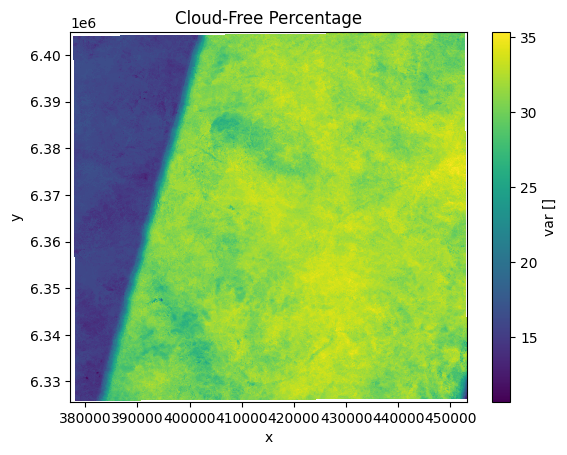

In [19]:
ds['var'].plot(cmap='viridis')
plt.title("Cloud-Free Percentage")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
